# Final Team Project - SliceWise: Pricing, Menu, and Ratings Analytics for U.S. Pizza Restaurants

### Team 9: Duy-Anh Dang, Arjun Venkatesh, and Nancy Walker

Course: ADS 505 Applied Data Science for Business

Instructor: Jules Malin

## Introduction

The Datafiniti dataset provides information on pizza restaurants in the United States. Information in this dataset includes restaurant names, locations, menu items, and prices. The goal of this analysis is to connect menu item type, pricing, and regional context to provide insights and recommendations on pricing strategies for pizza restaurant operators. Competitive pricing strategies can help pizza restaurants maximize revenue and attract more customers.

## Problem Statement

Predicting pizza prices by location, restaurant type, and menu items so companies can implement competitive pricing strategies.

## Exploratory Data Analysis

In [74]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder # preprocessing for numerical and categorical data
from sklearn.compose import ColumnTransformer # to apply different preprocessing to different columns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV # hyperparameter tuning
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor


from imblearn.over_sampling import SMOTENC # imblearn for handling class imbalance
from imblearn.pipeline import Pipeline # imblearn pipeline to handle resampling within cross-validation

from dateutil import parser # for parsing date strings

import kagglehub # to access Kaggle datasets
import os # to manage file paths

In [75]:
# Helpers

def ensure_dir(p: str) -> str:
    os.makedirs(p, exist_ok=True)
    return p

def coerce_numeric(df: pd.DataFrame, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def parse_dates(df: pd.DataFrame, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

def top_counts(s: pd.Series, n=20):
    return (
        s.dropna()
         .astype(str).str.strip()
         .replace("", np.nan).dropna()
         .value_counts()
         .head(n)
    )

In [76]:
# Download latest version
path = kagglehub.dataset_download("datafiniti/pizza-restaurants-and-the-pizza-they-sell")

print("Path to dataset files:", path)

Path to dataset files: /Users/nancywalker/.cache/kagglehub/datasets/datafiniti/pizza-restaurants-and-the-pizza-they-sell/versions/2


In [77]:
#Files downloaded
files = os.listdir(path)
print("Files downloaded:", files)

Files downloaded: ['8358_1.csv', 'Datafiniti_Pizza_Restaurants_and_the_Pizza_They_Sell_May19.csv']


In [78]:
# Select the first CSV file (assuming it exists)
csv_files = [f for f in files if f.endswith(".csv")] # Get all CSV file
print("CSV files found:", csv_files)

CSV files found: ['8358_1.csv', 'Datafiniti_Pizza_Restaurants_and_the_Pizza_They_Sell_May19.csv']


In [79]:
# Load the first CSV file found
# data1 = pd.read_csv(os.path.join(path, csv_files[0]))
# Have not used this dataset for analysis

# Load the second dataset
if len(csv_files) > 1:
    data2 = pd.read_csv(os.path.join(path, csv_files[1]))

In [80]:
# print the first few rows of the first dataset
# print(data1.head())
# Have not used this dataset for analysis

In [81]:
# print the first few rows of the second dataset
print(data2.head())

                     id             dateAdded           dateUpdated  \
0  AVz3Y-7h3D1zeR_xDAqm  2017-06-30T05:05:40Z  2019-05-01T15:43:09Z   
1  AVweGPFF_7pvs4fzAAzQ  2016-04-02T04:02:49Z  2019-05-01T15:27:50Z   
2  AVwdRGa9_7pvs4fz4E3K  2016-03-03T18:39:49Z  2019-05-01T12:52:25Z   
3  AVwdX4psIN2L1WUfvJB1  2016-03-29T05:08:59Z  2019-05-01T12:52:20Z   
4  AVwdaeTtkufWRAb55pSH  2016-03-31T02:34:04Z  2019-05-01T12:50:45Z   

             address                                         categories  \
0   4203 E Kiehl Ave  Pizza,Restaurant,American restaurants,Pizza Pl...   
1  25 E Camelback Rd                      Pizza,Pizza Place,Restaurants   
2    3703 Paxton Ave                 Restaurant,Pizza Place,Restaurants   
3    30495 John R Rd       Pizza,Carry-out food,Pizza Place,Restaurants   
4   3600 Eastern Ave  Pizza,American restaurants,Pizza Place,Pizza e...   

               primaryCategories             city country  \
0  Accommodation & Food Services         Sherwood      US   


Two possible datasets can be used for this project.

data1 is a list of over 3,500 pizzas from multiple restaurants.
- curated dataset of pizza-only restaurants in Datafiniti's business database.
- Useful for pizza-specific analyses.

Data2 is a list of 10,000 pizza restaurants in Datafiniti's business database, spanning **from January 2018 to May 2019**.
- a larger, broader subset of Datafiniti's business database.
- useful to analyze pizza restaurants in comparison to other types of restaurants.

In [82]:
# data1.info() # Have not used this dataset for analysis
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10000 non-null  object 
 1   dateAdded           10000 non-null  object 
 2   dateUpdated         10000 non-null  object 
 3   address             10000 non-null  object 
 4   categories          10000 non-null  object 
 5   primaryCategories   10000 non-null  object 
 6   city                10000 non-null  object 
 7   country             10000 non-null  object 
 8   keys                10000 non-null  object 
 9   latitude            10000 non-null  float64
 10  longitude           10000 non-null  float64
 11  menuPageURL         1679 non-null   object 
 12  menus.amountMax     10000 non-null  float64
 13  menus.amountMin     10000 non-null  float64
 14  menus.currency      10000 non-null  object 
 15  menus.dateSeen      10000 non-null  object 
 16  menus

Two possible datasets.

Dataset 1: 8358_1.csv
- This dataset contains information on pizza restaurants and the types of Pizza they sell.
- It has 3,519 rows and 21 columns.
- There are a few features with missing values.

Dataset 2: Datafiniti_Pizza_Restaurants_and_the_Pizza_They_Sell_May19.csv
- list of 10,000 restaurants in Datafiniti's business database between January 2018 and May 2019
- There are 24 feature columns
- Business listings include a variation of the phrase Pizza within the categories and menu.name variables
- fields have been flattened to make it easier to work with
- This dataset is a sample of a larger dataset that is available through Datafiniti's business database.


## Data2 Datafiniti Pizza Restaurants and the Pizza They Sell (May19)

In [83]:
# Data distribution
data2.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,10000.0,38.371895,4.573537,21.421326,34.422946,40.118880,40.905048,64.85050
longitude,10000.0,-90.063800,17.340379,-157.802443,-104.801126,-82.909949,-75.194741,-71.94617
menus.amountMax,10000.0,14.032670,17.607233,0.000000,8.490000,13.390000,17.950000,1395.00000
menus.amountMin,10000.0,13.416902,10.742678,0.000000,8.000000,12.990000,16.990000,243.00000
priceRangeMin,10000.0,4.655500,9.828412,0.000000,0.000000,0.000000,0.000000,50.00000
priceRangeMax,10000.0,27.764200,6.017526,7.000000,25.000000,25.000000,25.000000,55.00000


In [84]:
# Check for missing values
data2.isnull().sum()

id                       0
dateAdded                0
dateUpdated              0
address                  0
categories               0
primaryCategories        0
city                     0
country                  0
keys                     0
latitude                 0
longitude                0
menuPageURL           8321
menus.amountMax          0
menus.amountMin          0
menus.currency           0
menus.dateSeen           0
menus.description     6282
menus.name               0
name                     0
postalCode               4
priceRangeCurrency       0
priceRangeMin            0
priceRangeMax            0
province                 0
dtype: int64

There are a few features with missing values.

**Data2 Missing Values and Proposed Treatments:**

There are tree features with missing values in dataset 2.

- menuPageURL - 8,321 missing values ( Identifier/Link to the menu page on the business's website), leave as null and drop column
- menus.description - 6,282 missing values ( Description of the menu item)
    - Options: drop column, impute with placeholder string (for NLP), or transform to binary variable
- postalCode - 4 missing values ( Postal code of the business), impute with mode


*Data1 Missing Values and Proposed Treatments: (for reference only, have not used this dataset for analysis)*

- *menuPageURL - 2,900 missing values ( Identifier/Link to the menu page on the business's website), leave as null and drop column*
- *menu.amountMax - 562 missing values ( Maximum price of the menu item), impute with median*
- *menus.amountMin - 562 missing values ( Minimum price of the menu item), impute with median*
- *menus.currency - 559 missing values ( Currency of the menu item price), impute with mode*
- *menus.description - 1984 missing values ( Description of the menu item)*
    - *Options: drop column, impute with placeholder string (for NLP), or transform to binary variable*
- *postalCode - 26 missing values ( Postal code of the business), impute with mode*
- *priceRangeCurrency - 1953 missing values ( Currency of the price range), impute with mode*
- *priceRangeMin - 1953 missing values ( Minimum price of the price range), impute with median*
- *priceRangeMax - 1953 missing values ( Maximum price of the price range), impute with median*


In [85]:
# Remove identifier columns for modeling
data2_cleaned = data2.drop(columns=['id', 'categories', 'address', 'keys', 'menuPageURL']).copy()

# Impute missing values for numeric columns with the mean
# num_cols = data2_cleaned.select_dtypes(include=['float64', 'int64']).columns
# data2_cleaned[num_cols] = data2_cleaned[num_cols].fillna(data2_cleaned[num_cols].mean())
# Above code commented out because there are no missing valuse in numeric columns in dataset 2

# Impute missing values for categorical columns (postalCode is the only categorical variable in dataset 2 that needs impute)
# Impute with the mode
cat_cols = ['postalCode']
for col in cat_cols:
    mode_value = data2_cleaned[col].mode()[0]
    data2_cleaned[col] = data2_cleaned[col].fillna(mode_value)

# Create binary feature for menus.description and drop original column
data2_cleaned['has_description'] = np.where(data2_cleaned['menus.description'].notnull(), 1, 0)
data2_cleaned = data2_cleaned.drop(columns=['menus.description'])

# Verify no missing values remain
data2_cleaned.isnull().sum()

dateAdded             0
dateUpdated           0
primaryCategories     0
city                  0
country               0
latitude              0
longitude             0
menus.amountMax       0
menus.amountMin       0
menus.currency        0
menus.dateSeen        0
menus.name            0
name                  0
postalCode            0
priceRangeCurrency    0
priceRangeMin         0
priceRangeMax         0
province              0
has_description       0
dtype: int64

All missing values in dataset 2 have been treated.

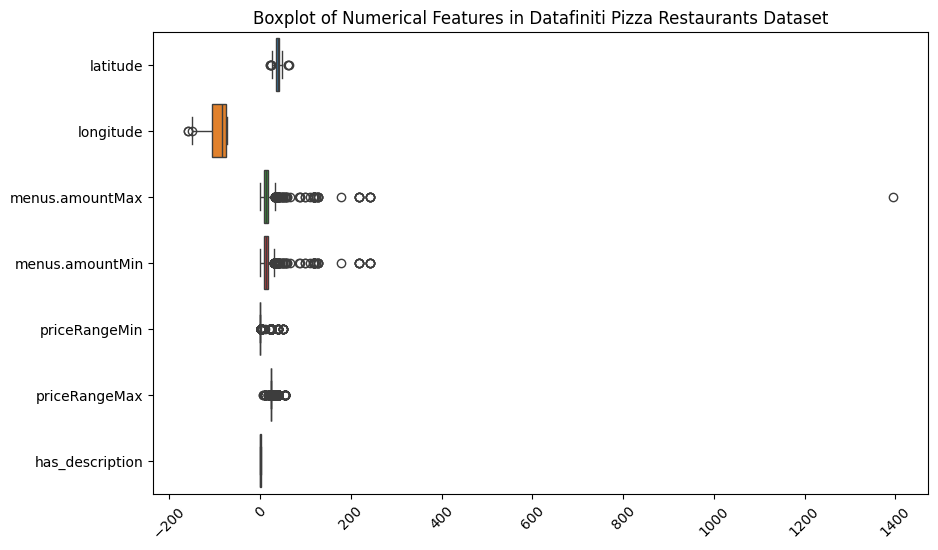

In [86]:
# Select numerical columns in Dataset 2
num_columns = data2_cleaned.select_dtypes(include=['float64','int64']).columns

# Boxplot for numerical features in Dataset 2
plt.figure(figsize=(10,6))
sns.boxplot(data=data2_cleaned[num_columns], orient='h')
plt.title('Boxplot of Numerical Features in Datafiniti Pizza Restaurants Dataset')
plt.xticks(rotation=45)
plt.show()


Menus.amountMax has an extreme outlier of a pizza that cost $1,395. This extreme value may be due to a data entry error or an expensive restaurant selling a luxury pizza. The outlier can be removed for analysis.

In [87]:
# remove the outlier in menus.amountMax
data2_cleaned = data2_cleaned[data2_cleaned['menus.amountMax']<500]


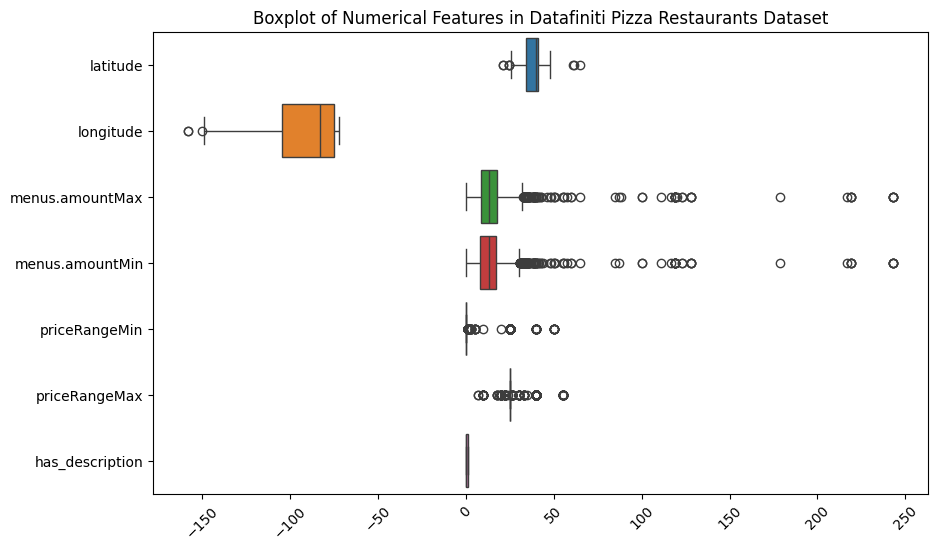

In [88]:
# Recheck data distribution after removig outlier
# Boxplot for numerical features in Dataset 2
plt.figure(figsize=(10,6))
sns.boxplot(data=data2_cleaned[num_columns], orient='h')
plt.title('Boxplot of Numerical Features in Datafiniti Pizza Restaurants Dataset')
plt.xticks(rotation=45)
plt.show()

A clear distribution of numerical features becomes visible once the extreme outlier is removed.

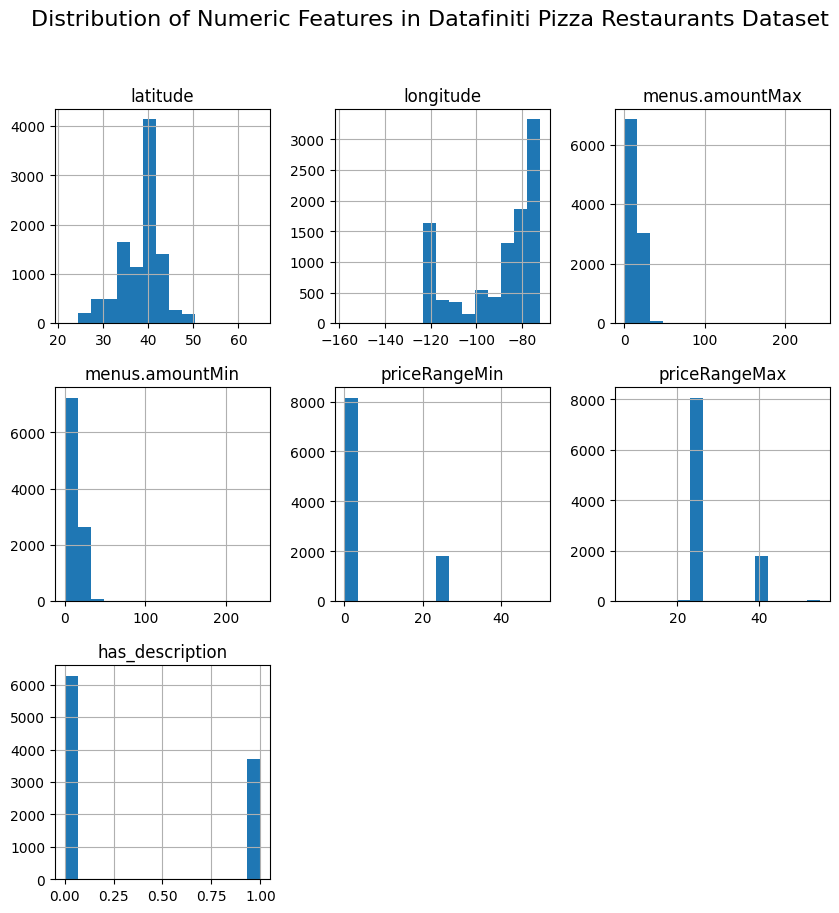

In [89]:
# Feature distribution of numeric features in Dataset 2
data2_cleaned[num_columns].hist(figsize=(10,10),bins=15)
plt.suptitle("Distribution of Numeric Features in Datafiniti Pizza Restaurants Dataset", fontsize =16)
plt.show()

The histogram also provides a clear visualization of the distribution of the numeric feature.

Longitude and latitude are continuous variables and display pizza location information.

- Options: keep as is, view mapping, compute distance reference point, group into regions, or use postal code/ city/ province/state to group instead of raw coordinates.

menus.amount Max and Min are continuous variables that display the price range of menu items. These variables are skewed right. (may need normalization/transformation for modeling)

priceRange Min and Max look as though they are categorical variables with numeric values. Likely displaying similar information to menus.amount Max and Min.

has_description is a binary variable that indicates whether the menu item has a description. This variable was created from the menus.description variable, which had many missing values.

<Axes: >

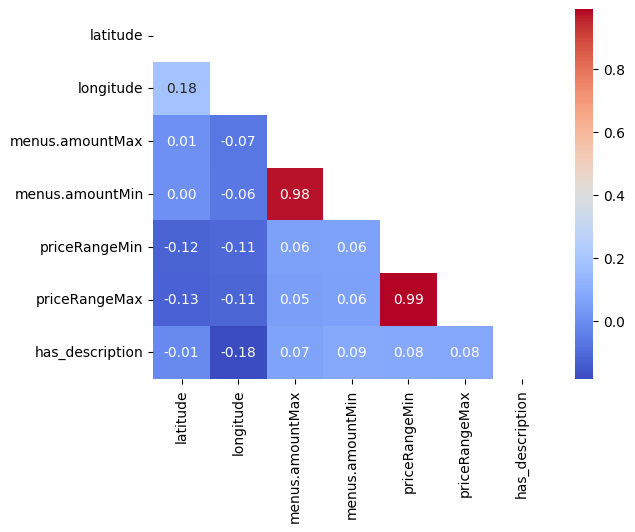

In [90]:
# Plot heatmap to visualize correlations
plt.figuresize=(10,8)
# creating mask to display only one triangle of the heatmap
mask = np.triu(np.ones_like(data2_cleaned[num_columns].corr()))

sns.heatmap(data2_cleaned[num_columns].corr(), annot=True, fmt=".2f", cmap='coolwarm', mask=mask)

Menus.amountMin and menus.amountMax are highly correlated (r = 0.98).
- Combine the average of these variables for a more flexible option of modeling pricing.

priceRangeMin and priceRangeMax are also highly correlated (r = 0.99).
- Combine the average of these variables for a more flexible option of modeling pricing.

All other numeric features have low correlation and can be kept as is for modeling.

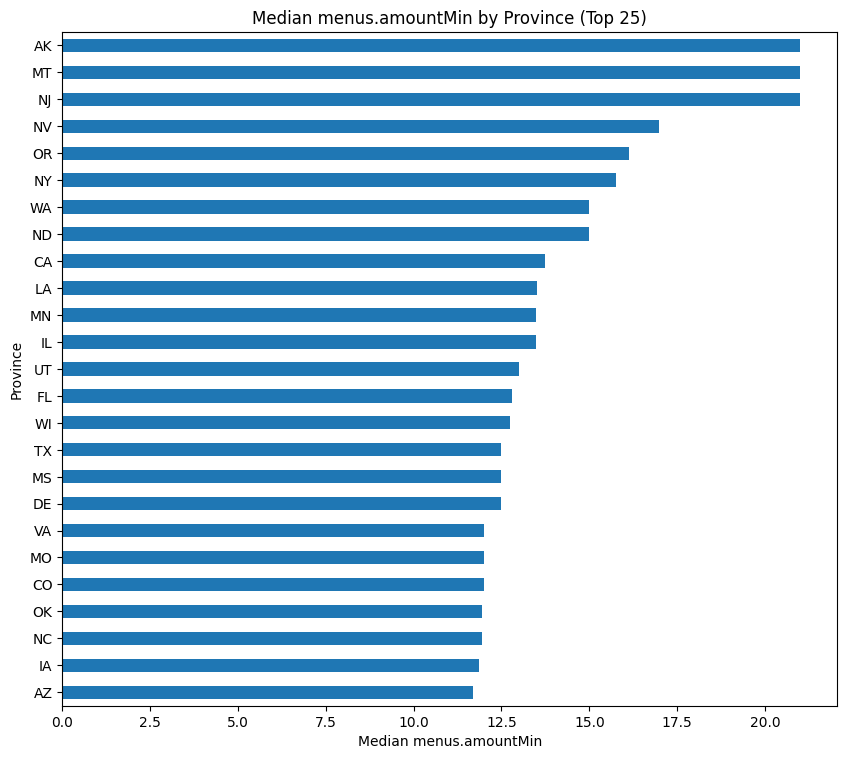

In [91]:
def plot_price_by_province(df: pd.DataFrame, outdir: str, tag: str):
    base = [c for c in ["menus.amountMin", "priceRangeMin"] if c in df.columns]
    if not base or "province" not in df.columns:
        return
    c = base[0]
    tmp = df.copy()
    tmp[c] = pd.to_numeric(tmp[c], errors="coerce")
    gp = tmp.groupby("province")[c].median().dropna().sort_values(ascending=False).head(25)
    if gp.empty:
        return
    plt.figure(figsize=(10, max(4, 0.35*len(gp))))
    gp.iloc[::-1].plot(kind="barh")
    plt.title(f"Median {c} by Province (Top 25)")
    plt.xlabel(f"Median {c}")
    plt.ylabel("Province")

plot_price_by_province(data2_cleaned, outdir=".", tag="data2_cleaned")
plt.show()

Chart displays the median price of menu items by province. AK, MT, and Nj have the highest median prices for menu items at around $20. AZ and IA have the lowest median prices for menu items at around $12. 

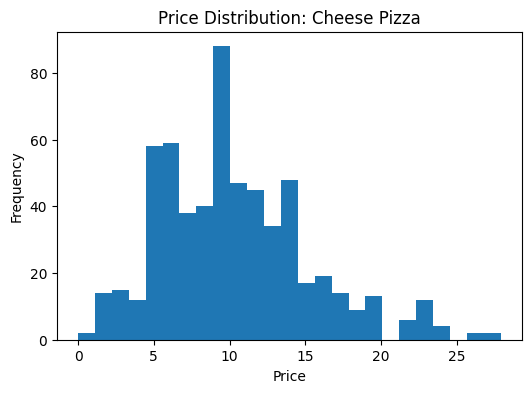

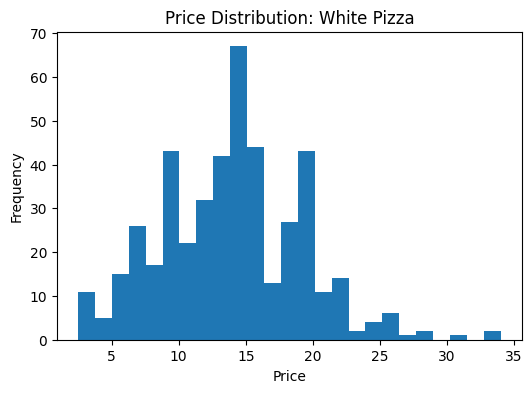

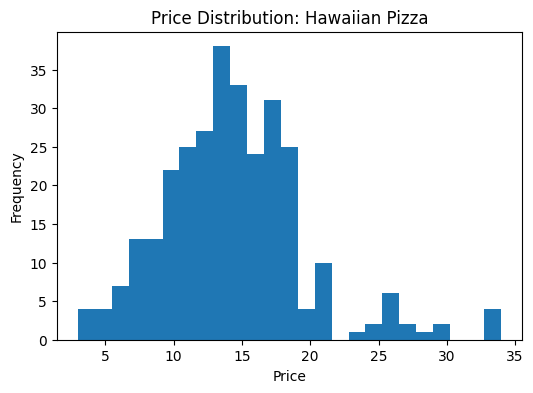

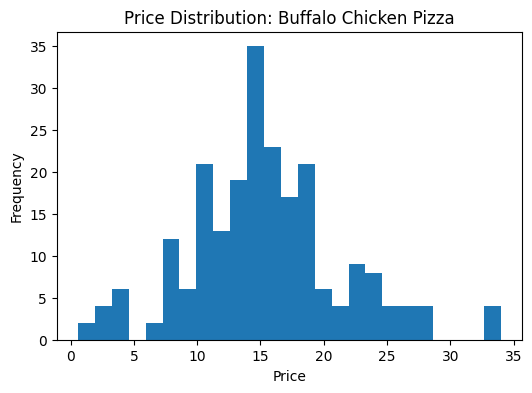

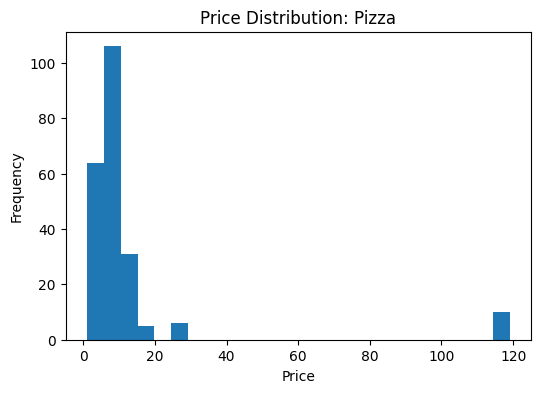

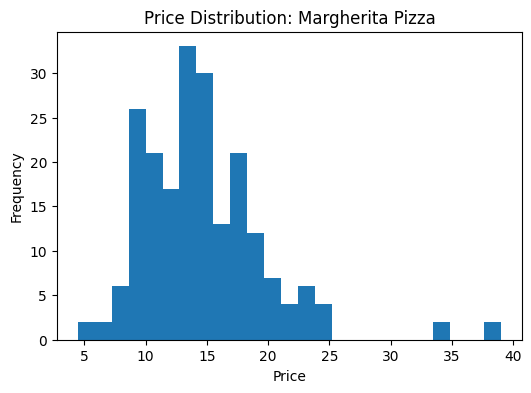

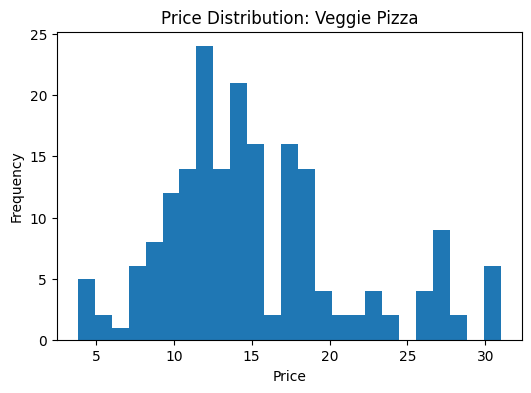

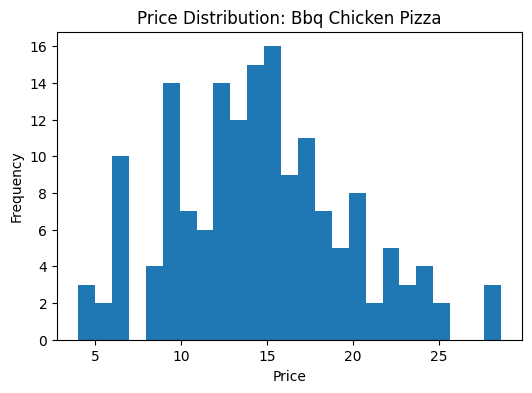

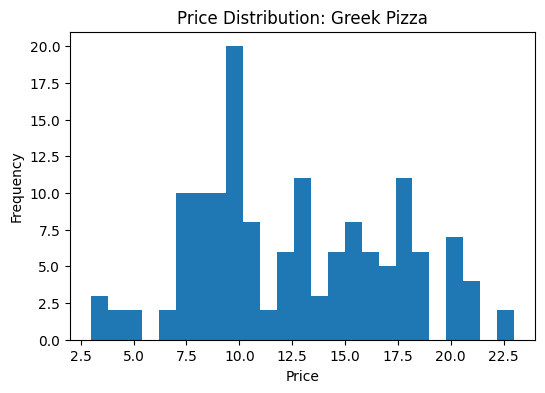

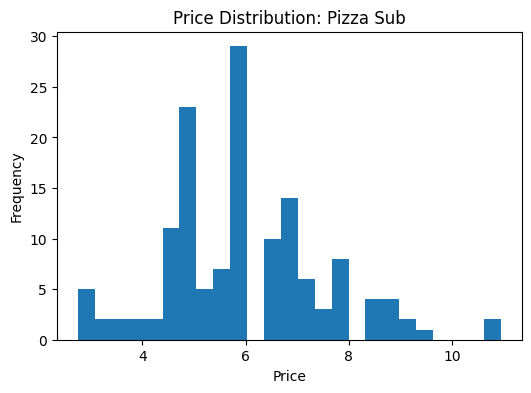

In [92]:
def plot_item_prices(df: pd.DataFrame, outdir: str, tag: str):
    if "menus.name" not in df.columns:
        return
    d = df.copy()
    for c in ["menus.amountMin", "menus.amountMax"]:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce")
    top_items = d["menus.name"].dropna().astype(str).value_counts().head(10).index.tolist()
    for item in top_items:
        sub = d[d["menus.name"].astype(str) == item]
        vals = []
        if "menus.amountMin" in sub.columns:
            vals.append(pd.to_numeric(sub["menus.amountMin"], errors="coerce"))
        if "menus.amountMax" in sub.columns:
            vals.append(pd.to_numeric(sub["menus.amountMax"], errors="coerce"))
        if not vals:
            continue
        s = pd.concat(vals).dropna()
        if s.empty:
            continue
        plt.figure(figsize=(6,4))
        s.plot(kind="hist", bins=25)
        plt.title(f"Price Distribution: {item}")
        plt.xlabel("Price")
        plt.ylabel("Frequency")

plot_item_prices(data2_cleaned, outdir=".", tag="data2_cleaned")
plt.show()

Before combining menus amount checkt the distribution of price for menue items (the pizza prices).

In [93]:
# check the pizza types in the menu items
top_counts(data2_cleaned['menus.name'], n=10)

menus.name
Cheese Pizza             299
White Pizza              225
Hawaiian Pizza           149
Buffalo Chicken Pizza    112
Pizza                    111
Margherita Pizza         104
Veggie Pizza              95
Bbq Chicken Pizza         81
Greek Pizza               72
Pizza Sub                 71
Name: count, dtype: int64

Categorize the top 10 pizza types in the menu items.

In [94]:
# Convert to lower case for consistency
data2_cleaned['menus.name'] = data2_cleaned['menus.name'].str.lower()

# Define mapping categories
def categorize_pizza(name):
    if "cheese" in name:
        return "cheese pizza"
    elif "white" in name:
        return "white pizza"
    elif "hawaiian" in name:
        return "hawaiian pizza"
    elif "buffalo" in name:
        return "buffalo chicken pizza"
    elif "veggie" in name or "vegetable" in name or "vegetarian" in name:
        return "veggie pizza"
    else:
        return "other"

# Apply categorization
data2_cleaned['pizza_type'] = data2_cleaned['menus.name'].apply(categorize_pizza)

# Check category counts
top_counts(data2_cleaned['pizza_type'], n=10)

pizza_type
other                    7557
cheese pizza             1140
white pizza               448
veggie pizza              405
hawaiian pizza            260
buffalo chicken pizza     189
Name: count, dtype: int64

In [95]:
# Check the names of the restaurants
top_counts(data2_cleaned['name'], n=10)

name
California Pizza Kitchen             261
Papa Murphy's                        208
Papa John's Pizza                    124
Papa Murphys                          69
Gino's Pizzeria                       68
Pirates Pizza                         55
Olympia Pizza and Spaghetti House     54
Round Table Pizza                     54
Domino's Pizza                        54
Pizza Hut                             51
Name: count, dtype: int64

There are many different restaurant names in the dataset. The top 10 restaurant names are shown above. Grouping into restrant chains vs independent restaurants may provide insights on pricing strategies. Restrants that appear more than once in the top 10 will be considered chains for this analysis.

In [96]:
# Count restaurants that appear more than once in the top 10
name_counts = data2_cleaned['name'].value_counts()

# Define a threshold for chain restaurants
chain_threshold = 10 

# Mark chain vs independent restaurants
data2_cleaned['is_chain'] = data2_cleaned['name'].apply(lambda x: 1 if name_counts.get(x, 0) >= chain_threshold else 0)

# check the primary categories
top_counts(data2_cleaned['is_chain'], n=10)

is_chain
1    5262
0    4737
Name: count, dtype: int64

is_chain = 1 means ther is at least 10 restaurants with the same name in the dataset. 

is_chain = 0 means the restaurant name appears less than 10 times in the dataset.

In [97]:
# check the primary categories
top_counts(data2_cleaned['primaryCategories'], n=10)

primaryCategories
Accommodation & Food Services                                          9908
Management of Companies & Enterprises                                    43
Accommodation & Food Services,Management of Companies & Enterprises      23
Retail,Accommodation & Food Services                                     11
Retail                                                                    9
Wholesale Trade,Accommodation & Food Services                             2
Educational Services,Accommodation & Food Services                        2
Wholesale Trade,Accommodation & Food Services,Manufacturing               1
Name: count, dtype: int64

There are 8 primary categories in the dataset. Most restaurants are in category Accommodation and Food Services. Simplify inot Accommodation and Food Services vs Other.

In [98]:
# Simplify primary categories into Accommodation and Food Services vs Other
def simplify_primary_category(category):
    if category == "Accommodation & Food Services":
        return "Accommodation & Food Services"
    else:
        return "Other"

data2_cleaned['primaryCategories'] = data2_cleaned['primaryCategories'].apply(simplify_primary_category)

data2_cleaned['primaryCategories'].value_counts()

primaryCategories
Accommodation & Food Services    9908
Other                              91
Name: count, dtype: int64

Simplify primary categories into Accommodation and Food Services vs Other to reduce noise. 

In [99]:
# Combine highly correlated features into average features
data2_cleaned['menus_amount_avg'] = (data2_cleaned['menus.amountMin'] + data2_cleaned['menus.amountMax']) / 2
data2_cleaned['priceRange_avg'] = (data2_cleaned['priceRangeMin'] + data2_cleaned['priceRangeMax']) / 2
# Drop original highly correlated features
data2_cleaned = data2_cleaned.drop(columns=['menus.amountMin', 'menus.amountMax', 'priceRangeMin', 'priceRangeMax'])

In [100]:
# Check the unique values across all columns in Dataset 2
data2_cleaned.nunique()

dateAdded             2214
dateUpdated           2193
primaryCategories        2
city                  1028
country                  1
latitude              2284
longitude             2284
menus.currency           1
menus.dateSeen        6303
menus.name            4662
name                  1827
postalCode            1771
priceRangeCurrency       1
province                44
has_description          2
pizza_type               6
is_chain                 2
menus_amount_avg       858
priceRange_avg          18
dtype: int64

**Timestamp variables**: dateAdded, dateUpdated, menus.dateSeen
- extract features: year, month, day, day of week, elapsed time since (for dateAdded and dateUpdated)
- drop after extracting features (high-cardinality categorical variable)

**Drop**

- County, meanus.currency, and priceRangeCurrency only have one unique value. These columns can be dropped.
- name high cardinality categorical variable, (not useful unless store-level predictions are needed) 
    - group into top names vs other (will provide information on pricing strategies on chains vs independent restaurants)
- menus.name; Too high-cardinality unless top items are grouped. Group into top pizza types (cheese pizza, white pizza, hawaiian pizza, buffalo chicken pizza, and veggie pizza) and "Other"

**Leave as is**

has_description is a binary variable that was created to indicate if a menu has a description or not.

**one-hot encoded for modeling**

low-cardinality categorical variables:
- primaryCategories: pizza type
- province: region-level location (linear models could group into larger regions)


One-hot encoding will occur in the model pipeline to avoid the dummy variable trap.


High-cardinality categorical variables: menus.dateSeen
- city: city-level location; could blow up the model with too many features. To capture city-level location, keep the top N cities and group the rest into "Other"
- postalCode: zip code-level location; could blow up model with too many features
    - drop in information already captured in other features

**Location**
longitude, latitude
- keep as continuous variables for tree-based models
- could compute distance from reference point (e.g., city center) or group into regions for linear models

**Dependent variables for modeling:**

priceRangeAverage or menus_amount_avg

Dependent Variable: Goal is to recommend pricing strategies for pizza restaurants.

Menu.amountMax: Maximum price of the menu item

- Continuous variable, good for regression modeling
- recommend exact menu pricing based on other features

or

priceRangeMax: Maximum price of the price range

- Ordinal variable, good for classification modeling
- recommend price range categories based on other features (ie, budget, mid-range, premium)




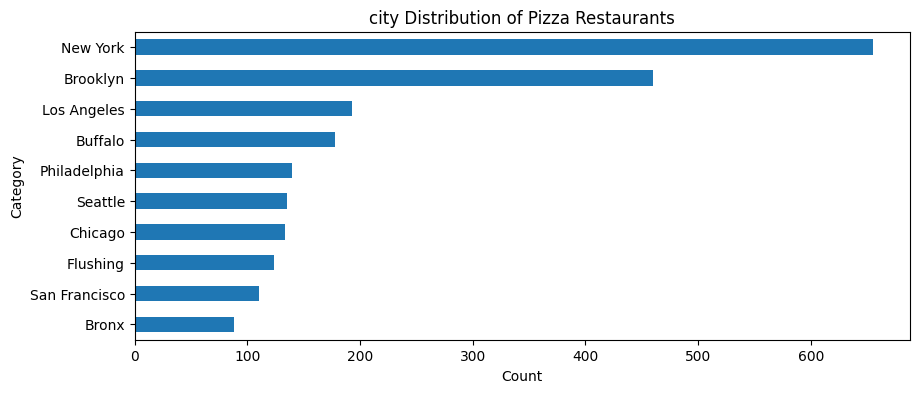

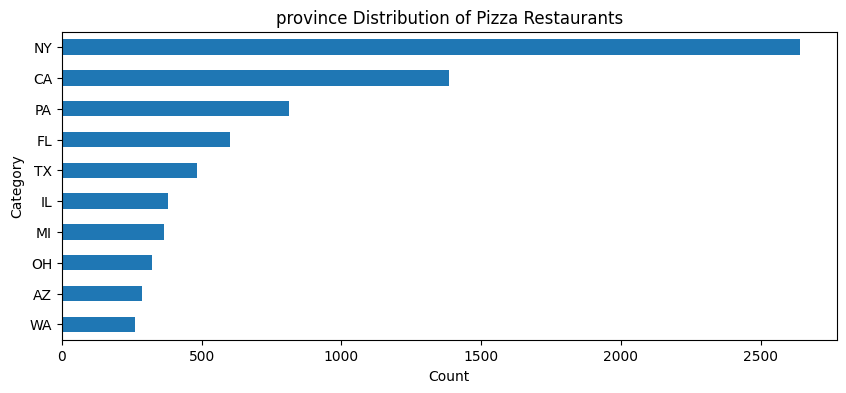

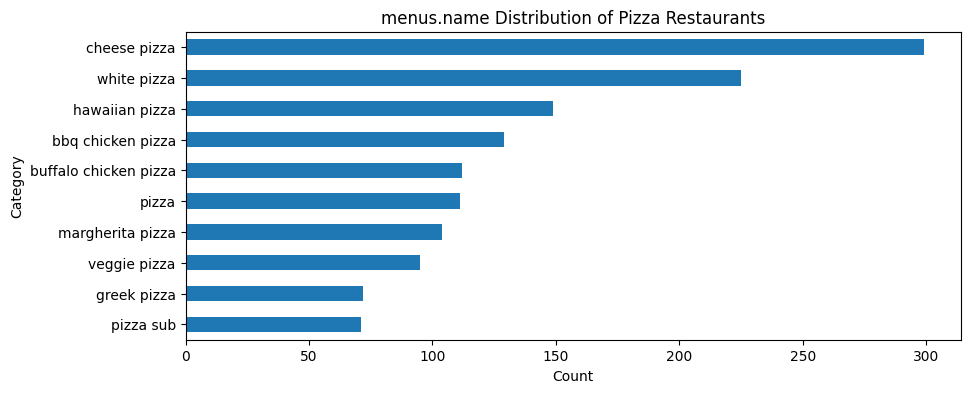

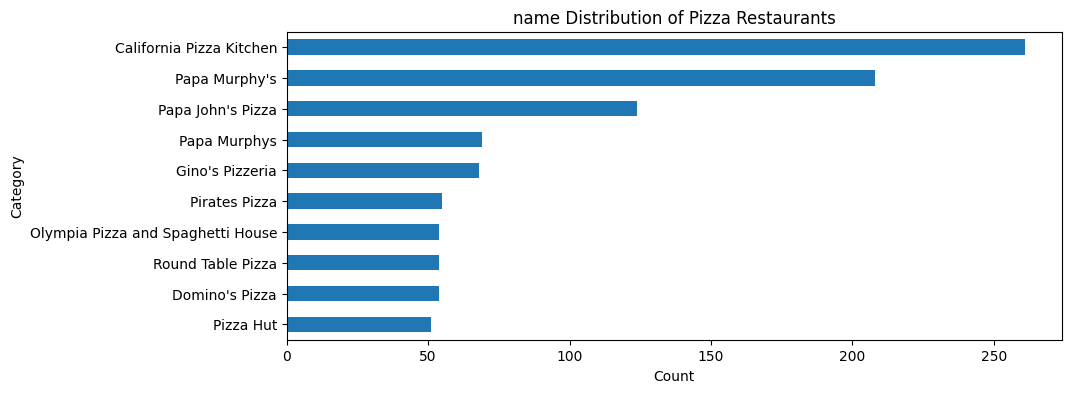

In [101]:
def plot_top_cat(s: pd.Series, outdir: str, tag: str, title: str, n=25):
    vc = top_counts(s, n=n)
    if vc.empty:
        return
    plt.figure(figsize=(10, max(4, 0.35*len(vc))))
    vc.iloc[::-1].plot(kind="barh")
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Category")

def plot_price_dist(df, run_out, data2_cleaned):
    plot_item_prices(df, run_out, data2_cleaned)
    for col, title in [
        ("city", "Top Cities"),
        ("province", "Top Provinces/States"),
        ("menus.name", "Top Menu Items"),
        ("name", "Top Restaurant Names"),
        ("categories", "Top Raw Categories"),
    ]:
        if col in df.columns:
            plot_top_cat(df[col], run_out, data2_cleaned, title, n=25)

col_list = ["city", "province", "menus.name", "name", "categories"]

for col in col_list:
    if col in data2_cleaned.columns:
        plot_top_cat(data2_cleaned[col], outdir=".", tag=col,
        title=f"{col} Distribution of Pizza Restaurants", n=10)

plt.show()

New York had the most pizza restaurants. Cheese pizza was the most common menu item. California Pizza Kitchen is the most common pizza restaurant chain.

In [102]:
# Drop variable with one unique value, high-cardinality variables, and variables that have been transformed into other features
data2_cleaned = data2_cleaned.drop(columns=['country','menus.currency', 'priceRangeCurrency', 'postalCode', 'menus.name', 'name'])

In [103]:
data2_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dateAdded          9999 non-null   object 
 1   dateUpdated        9999 non-null   object 
 2   primaryCategories  9999 non-null   object 
 3   city               9999 non-null   object 
 4   latitude           9999 non-null   float64
 5   longitude          9999 non-null   float64
 6   menus.dateSeen     9999 non-null   object 
 7   province           9999 non-null   object 
 8   has_description    9999 non-null   int64  
 9   pizza_type         9999 non-null   object 
 10  is_chain           9999 non-null   int64  
 11  menus_amount_avg   9999 non-null   float64
 12  priceRange_avg     9999 non-null   float64
dtypes: float64(4), int64(2), object(7)
memory usage: 1.1+ MB


## Handle Timestamp Variables

In [104]:
# check the formate of the data and time variables
print("dateAdded: \n", data2_cleaned['dateAdded'].head(2))
print("dateUpdated: \n", data2_cleaned['dateUpdated'].head(2))
print("menus.dateSeen: \n", data2_cleaned['menus.dateSeen'].head(2))


dateAdded: 
 0    2017-06-30T05:05:40Z
1    2016-04-02T04:02:49Z
Name: dateAdded, dtype: object
dateUpdated: 
 0    2019-05-01T15:43:09Z
1    2019-05-01T15:27:50Z
Name: dateUpdated, dtype: object
menus.dateSeen: 
 0    2018-05-01T04:25:37.197Z,2018-04-16T04:36:02.3...
1    2018-03-03T02:38:06.381Z,2018-01-18T20:18:10.0...
Name: menus.dateSeen, dtype: object


dataAdded and dataUpdated can easily be converted to a datetime format.

Menus.dateSeen has many comma-separated values from multiple updates. Tricky to convert to a datetime format.
- Dropping this variable will still capture price recommendations, but will lose seasonality trends in pricing.
- Keeping this variable will show seasonality trends in pricing, but will make modeling more difficult.
- Variable can be engineered into recency span to capture how long the menu has been tracked.

In [105]:
# Change data formate of date columns to datetime data type
data2_cleaned['dateAdded'] = pd.to_datetime(data2_cleaned['dateAdded'], errors='coerce', utc=True)
data2_cleaned['dateUpdated'] = pd.to_datetime(data2_cleaned['dateUpdated'], errors='coerce', utc=True)

In [106]:
# Extract year, month, day, and day of week from dateAdded
# data2_cleaned['dateAdded_year'] = data2_cleaned['dateAdded'].dt.year
# year infromation is captured in days_since_added feature
data2_cleaned['dateAdded_month'] = data2_cleaned['dateAdded'].dt.month
# data2_cleaned['dateAdded_day'] = data2_cleaned['dateAdded'].dt.day
# day infroamtion is captured in dateAdded_dayofweek feature
data2_cleaned['dateAdded_dayofweek'] = data2_cleaned['dateAdded'].dt.dayofweek
# Elapsed time since dateAdded
data2_cleaned['days_since_added'] = (pd.Timestamp.now(tz='UTC') - data2_cleaned['dateAdded']).dt.days

#  Extract year, month, day, and day of week from dateUpdated
# data2_cleaned['dateUpdated_year'] = data2_cleaned['dateUpdated'].dt.year
# year infromation is captured in days_since_updated feature
data2_cleaned['dateUpdated_month'] = data2_cleaned['dateUpdated'].dt.month
# data2_cleaned['dateUpdated_day'] = data2_cleaned['dateUpdated'].dt.day
# day infroamtion is captured in dateUpdated_dayofweek feature
data2_cleaned['dateUpdated_dayofweek'] = data2_cleaned['dateUpdated'].dt.dayofweek
# Elapsed time since dateUpdated
data2_cleaned['days_since_updated'] = (pd.Timestamp.now(tz='UTC') - data2_cleaned['dateUpdated']).dt.days

In [107]:
# Compute recency span of menus.dateSeen
def date_span(s):
    if pd.isna(s):
        return 0
    dates = [parser.parse(d) for d in str(s).split(',')]
    return (max(dates) - min(dates)).days if len(dates) > 1 else 0

data2_cleaned['menus_dates_span'] = data2_cleaned['menus.dateSeen'].apply(date_span)


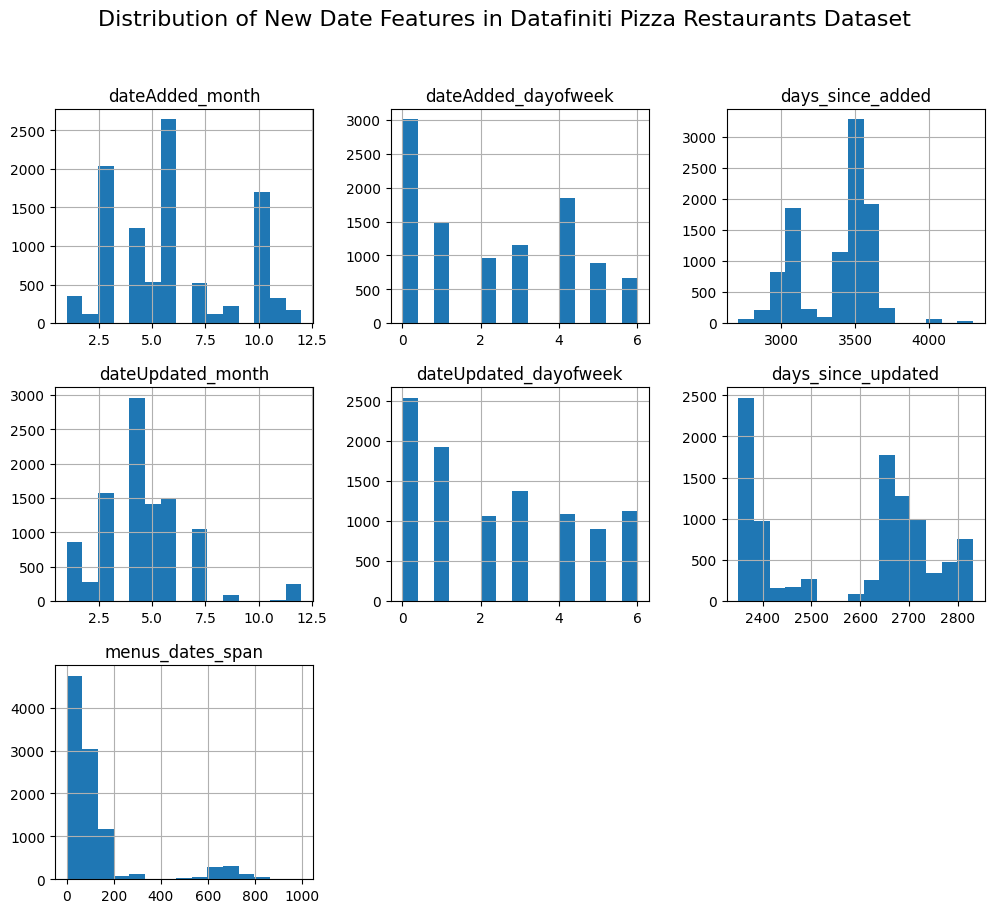

In [108]:
# visulize the distribution of the new date features
new_date_features = ['dateAdded_month', 'dateAdded_dayofweek',
                     'days_since_added', 'dateUpdated_month',
                     'dateUpdated_dayofweek', 'days_since_updated', 'menus_dates_span']
data2_cleaned[new_date_features].hist(figsize=(12,10), bins=15)
plt.suptitle("Distribution of New Date Features in Datafiniti Pizza Restaurants Dataset", fontsize=16)
plt.show()

Month and days fo the week variable are categorical variables with numeric values. Can be one-hot encoded for linear modeling.

All other timestamp variables are continuous variables.

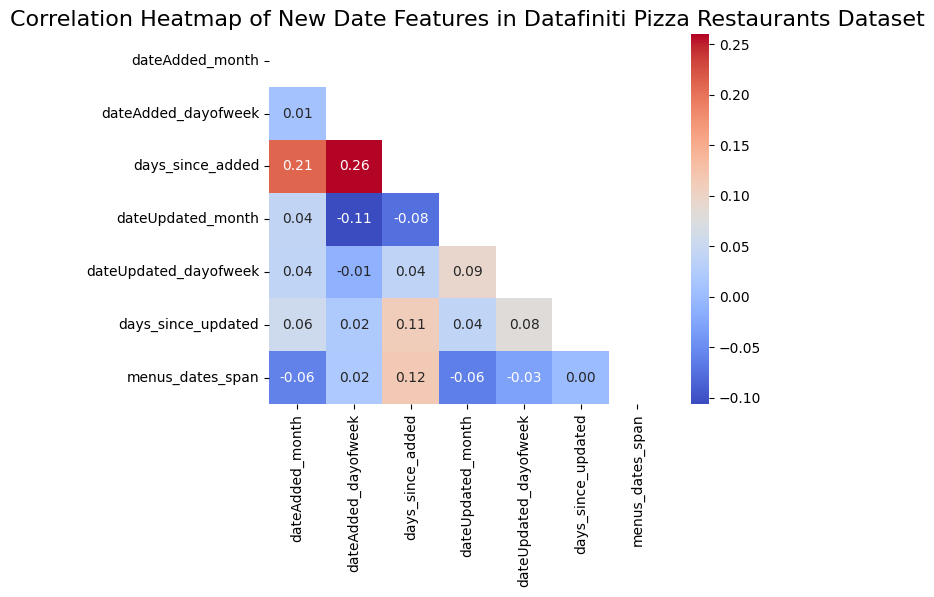

In [109]:
# Check the correlation of the new date features
plt.figuresize=(10,8)
# creating mask to display only one triangle of the heatmap
mask = np.triu(np.ones_like(data2_cleaned[new_date_features].corr()))
sns.heatmap(data2_cleaned[new_date_features].corr(), annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.title("Correlation Heatmap of New Date Features in Datafiniti Pizza Restaurants Dataset", fontsize=16)
plt.show()

All timestap variables are showing low to moderate correlation with eachother.

In [110]:
# Drop original date columns
data2_cleaned = data2_cleaned.drop(columns=['dateAdded', 'dateUpdated', 'menus.dateSeen'])

In [111]:
# Check data types
data2_cleaned.dtypes

primaryCategories         object
city                      object
latitude                 float64
longitude                float64
province                  object
has_description            int64
pizza_type                object
is_chain                   int64
menus_amount_avg         float64
priceRange_avg           float64
dateAdded_month            int32
dateAdded_dayofweek        int32
days_since_added           int64
dateUpdated_month          int32
dateUpdated_dayofweek      int32
days_since_updated         int64
menus_dates_span           int64
dtype: object

In [112]:
# All numeric features in Dataset 2
all_numeric_features = data2_cleaned.select_dtypes(include=['float64','int64', 'int32']).columns

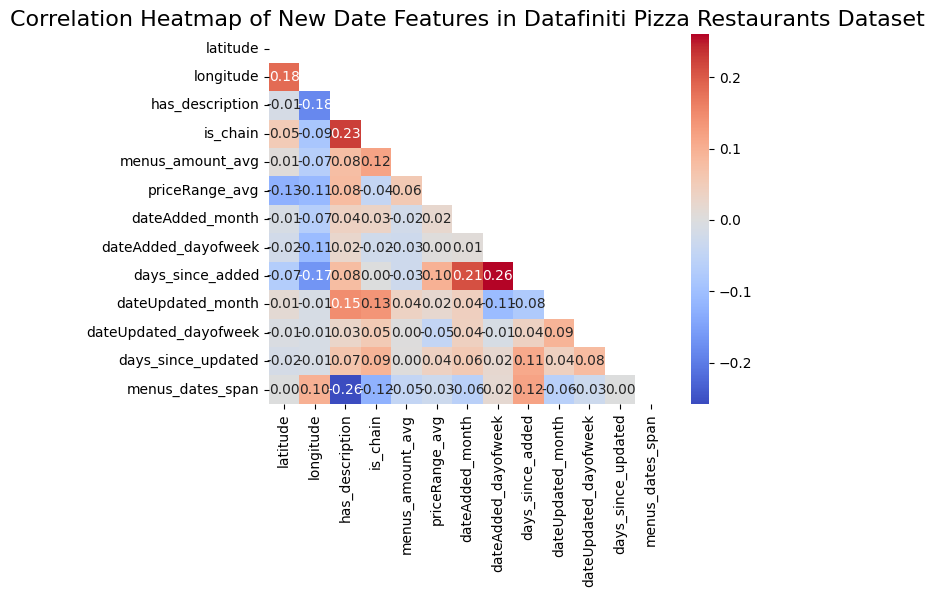

In [113]:
# Check correlation heatmap of all numeric features to ensure no other high correlations exist
plt.figuresize=(12,10)
# creating mask to display only one triangle of the heatmap
mask = np.triu(np.ones_like(data2_cleaned[all_numeric_features].corr()))
sns.heatmap(data2_cleaned[all_numeric_features].corr(), annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.title("Correlation Heatmap of New Date Features in Datafiniti Pizza Restaurants Dataset", fontsize=16)
plt.show()

Most numeric features exhibit low correlation with one another.

Additionally, there is a low correlation with the dependent variables' priceRangeAverage and menus_amount_avg.

Linear relationships are weak, tree-based models may perform better.

## Longitude and Latitude and city

- keep as continuous variables for tree-based models
- could compute distance from reference point (e.g., city center) or group into regions for linear models

- city: city-level location; could blow up the model with too many features. To capture city-level location, keep the top N cities and group the rest into "Other"

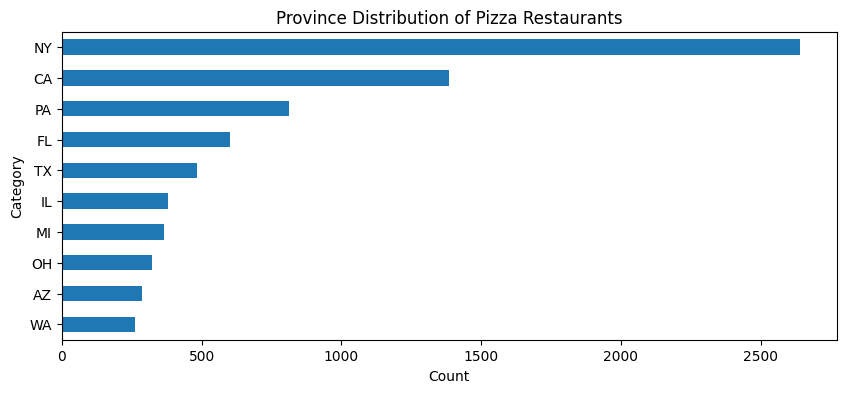

In [114]:
def plot_top_cat(s: pd.Series, outdir: str, tag: str, title: str, n=25):
    vc = top_counts(s, n=n)
    if vc.empty:
        return
    plt.figure(figsize=(10, max(4, 0.35*len(vc))))
    vc.iloc[::-1].plot(kind="barh")
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Category")
    return plt.show()

plot_top_cat(
    data2_cleaned['province'],
    outdir=".",
    tag="province",
    title="Province Distribution of Pizza Restaurants",
    n=10
)

New York had the most pizza restaurants. 

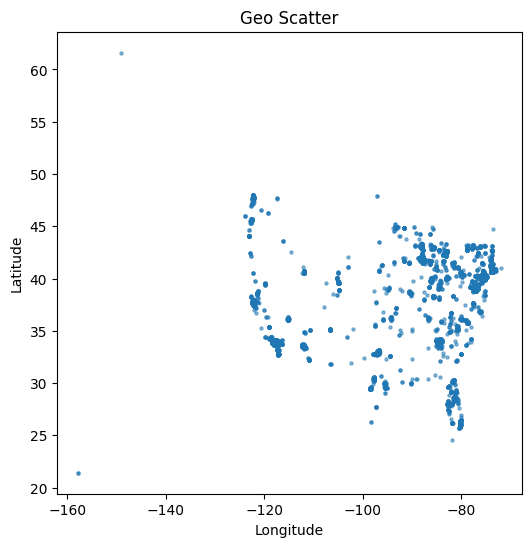

In [115]:
def plot_geo(df: pd.DataFrame, outdir: str, tag: str, sample=5000):
    need = {"latitude", "longitude"}
    if not need.issubset(df.columns):
        return
    pts = df[["latitude", "longitude"]].dropna()
    if len(pts) == 0:
        return
    if len(pts) > sample:
        pts = pts.sample(sample, random_state=42)
    plt.figure(figsize=(6,6))
    plt.scatter(pts["longitude"], pts["latitude"], s=5, alpha=0.5)
    plt.title("Geo Scatter")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

plot_geo(data2_cleaned, outdir=".", tag="data2_cleaned")
plt.show()

The density of pizza restaurants across the nation is highest in the northeast United States and California.

In [116]:
# Group into regions based on longitude and latitude
# Define function to categorize into regions
def categorize_region(lat, lon):
    if lat >= 40.0:
        return 'North'
    elif lat <= 30.0:
        return 'South'
    elif lon <= -120.0:
        return 'West'
    elif lon >= -80.0:
        return 'East'
    else:
        return 'Central'

data2_cleaned['region'] = data2_cleaned.apply(lambda row: categorize_region(row['latitude'], row['longitude']), axis=1)
# Keep region and drop original longitude and latitude for tree-based models

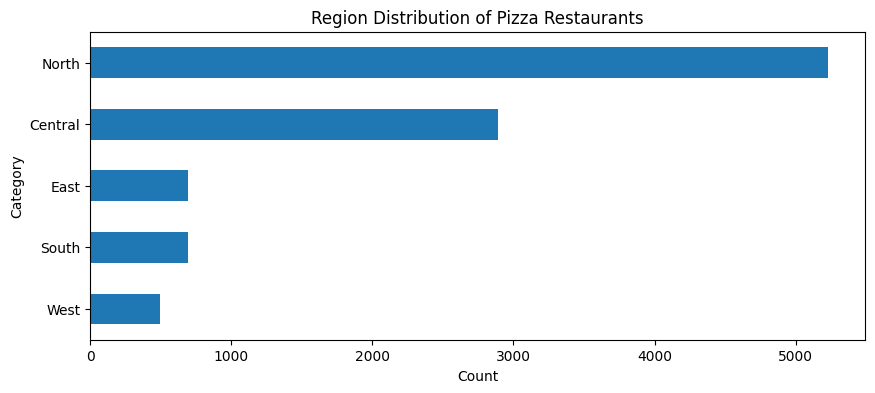

In [117]:
def plot_top_cat(s: pd.Series, outdir: str, tag: str, title: str, n=25):
    vc = top_counts(s, n=n)
    if vc.empty:
        return
    plt.figure(figsize=(10, max(4, 0.35*len(vc))))
    vc.iloc[::-1].plot(kind="barh")
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Category")
    return plt.show()

plot_top_cat(
    data2_cleaned['region'],
    outdir=".",
    tag="region",
    title="Region Distribution of Pizza Restaurants",
    n=10
)

Highest distribution of pizza restaurants in the North region of the US.

### Grouped Variable

In [118]:
# Create a grouped city variable
top_cities = data2_cleaned['city'].value_counts().nlargest(10).index
data2_cleaned['city_grouped'] = data2_cleaned['city'].apply(lambda x: x if x in top_cities else 'Other')
# Drop original city column
data2_cleaned = data2_cleaned.drop(columns=['city'])

In [119]:
# Group rare classes in priceRange_avg to avoid value error when splitting data into train and test sets with stratify=y
# Check the distribution of priceRange_avg
print(data2_cleaned['priceRange_avg'].value_counts())

priceRange_avg
12.5    7979
32.5    1801
13.5      54
13.0      31
11.5      28
47.5      21
10.5      18
15.0      16
5.0       16
52.5       9
17.5       8
16.5       5
10.0       4
14.0       4
3.5        2
18.0       1
14.5       1
25.0       1
Name: count, dtype: int64


In [120]:
# Group rare classes into 'Other'
rare_classes = data2_cleaned['priceRange_avg'].value_counts()[data2_cleaned['priceRange_avg'].value_counts() < 10].index
data2_cleaned['priceRange_avg'] = data2_cleaned['priceRange_avg'].apply(lambda x: 'Other' if x in rare_classes else x)

# Check the distribution again
print(data2_cleaned['priceRange_avg'].value_counts())

priceRange_avg
12.5     7979
32.5     1801
13.5       54
Other      35
13.0       31
11.5       28
47.5       21
10.5       18
15.0       16
5.0        16
Name: count, dtype: int64


10 main classes with average price ranges greater than 10 samples. Much more stable for classification.

## Data Wrangling and Pre-Processing

In [121]:
# Separate features and target variable
X = data2_cleaned.drop(columns=['menus_amount_avg', 'priceRange_avg']) # Features
# Regression target variable
y_reg = data2_cleaned['menus_amount_avg'].astype(float) # Target variable: recomended exact menue price
# Classification target variable
y_clf = data2_cleaned['priceRange_avg'].astype(str) # Target variable: recomended price range average

priceRange_avg produced the value error " The least populated class in y has only one member, which is too few. The minimum number of groups for any class cannot be less than 2." When splitting the data into train and test sets with stratify=y. This error may be because priceRange_avg has a band with one sample.

menus_amount_avg is a continuous variable suitable for regression modeling. The goal is to recommend exact menu pricing based on other features.

priceRange_avg is an ordinal variable suitable for classification modeling. The goal is to recommend price range categories based on other features (ie, budget, mid-range, premium).

- Option to use priceRange_avg: group rare classes or bin into fewer categories to avoid value error when splitting data into train and test sets.

        **menus_amount_avg:** regression task (continuous target).

        **priceRange_avg:** classification task (discrete bins).

### Data Splitting

In [122]:
# Split the data into training and validation sets
# Classification target
train_X, temp_X, train_y_clf, temp_y_clf = train_test_split(X, y_clf, test_size=0.4, random_state=1, stratify=y_clf)

# Split validation data into validation and test sets
valid_X, test_X, valid_y_clf, test_y_clf = train_test_split(temp_X, temp_y_clf, test_size=0.5, random_state=1, stratify=temp_y_clf)

# Check the shape of the predictors in the datasets
print(train_X.shape, valid_X.shape, test_X.shape)

(5999, 16) (2000, 16) (2000, 16)


In [123]:
# Regression target using same indices as classification target
train_y_reg = y_reg.loc[train_y_clf.index]
valid_y_reg = y_reg.loc[valid_y_clf.index]
test_y_reg = y_reg.loc[test_y_clf.index]

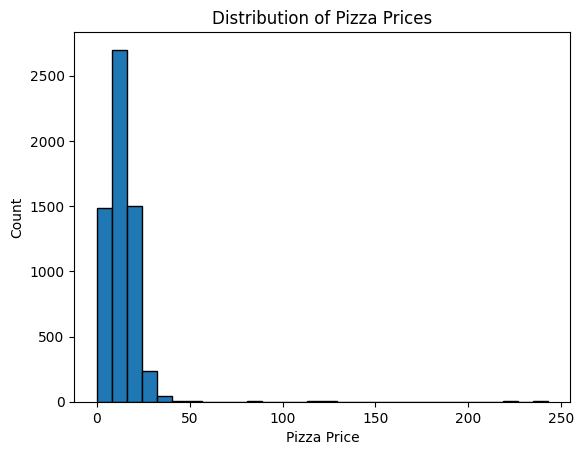

In [124]:
# Check if log transformation is needed for regression target
plt.hist(train_y_reg, bins=30, edgecolor='k')
plt.xlabel("Pizza Price")
plt.ylabel("Count")
plt.title("Distribution of Pizza Prices")
plt.show()

The regression trarget variable is right skewed with outliers. Log transformation may help normalize the distribution and improve model performance.

In [125]:
train_y_log = np.log1p(train_y_reg)   # log(1+y)
valid_y_log = np.log1p(valid_y_reg)
test_y_log  = np.log1p(test_y_reg )

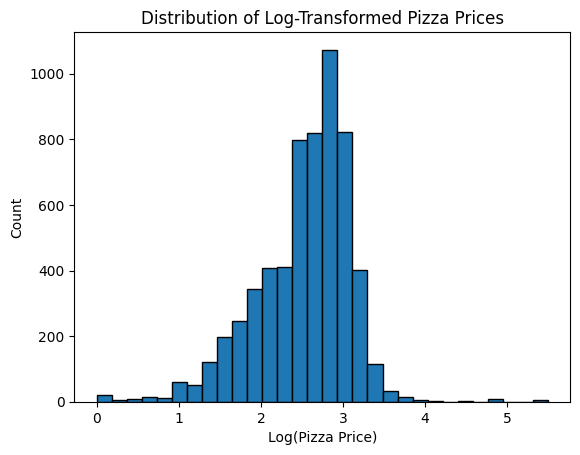

In [126]:
# Histogram after log-transformation 
plt.hist(np.log1p(train_y_reg), bins=30, edgecolor='k')
plt.xlabel("Log(Pizza Price)")
plt.ylabel("Count")
plt.title("Distribution of Log-Transformed Pizza Prices")
plt.show()

Data is now normally distributed after log transformation.

In [127]:
data2_cleaned.dtypes

primaryCategories         object
latitude                 float64
longitude                float64
province                  object
has_description            int64
pizza_type                object
is_chain                   int64
menus_amount_avg         float64
priceRange_avg            object
dateAdded_month            int32
dateAdded_dayofweek        int32
days_since_added           int64
dateUpdated_month          int32
dateUpdated_dayofweek      int32
days_since_updated         int64
menus_dates_span           int64
region                    object
city_grouped              object
dtype: object

In [128]:
# Features for different models
linear_features = [
    'primaryCategories', 'region', 'has_description', 'pizza_type',
    'dateAdded_month', 'dateAdded_dayofweek', 'days_since_added',
    'dateUpdated_month', 'dateUpdated_dayofweek', 'days_since_updated',
    'menus_dates_span'
]

tree_features = [
    'primaryCategories', 'latitude', 'longitude', 'province',
    'has_description', 'pizza_type',
    'dateAdded_month', 'dateAdded_dayofweek', 'days_since_added',
    'dateUpdated_month', 'dateUpdated_dayofweek', 'days_since_updated',
    'menus_dates_span', 'city_grouped', 'is_chain'
]

knn_features = [
    'primaryCategories', 'latitude', 'longitude', 'region',
    'pizza_type', 'days_since_added', 'days_since_updated',
    'menus_dates_span'
]

svm_features = [
    'primaryCategories', 'region', 'has_description', 'pizza_type',
    'dateAdded_month', 'dateAdded_dayofweek', 'days_since_added',
    'days_since_updated', 'menus_dates_span'
]

nn_features = [
    'primaryCategories', 'latitude', 'longitude', 'province',
    'has_description', 'pizza_type',
    'dateAdded_month', 'dateAdded_dayofweek', 'days_since_added',
    'dateUpdated_month', 'dateUpdated_dayofweek', 'days_since_updated',
    'menus_dates_span', 'city_grouped', 'is_chain'
]

In [129]:
# Create variables for modelign pipeline
# Linear
train_X_linear = train_X[linear_features].copy()
valid_X_linear = valid_X[linear_features].copy()
test_X_linear  = test_X[linear_features].copy()

# Tree
train_X_tree = train_X[tree_features].copy()
valid_X_tree = valid_X[tree_features].copy()
test_X_tree  = test_X[tree_features].copy()

# KNN
train_X_knn = train_X[knn_features].copy()
valid_X_knn = valid_X[knn_features].copy()
test_X_knn = test_X[knn_features].copy()

# SVM
train_X_svm = train_X[svm_features].copy()
valid_X_svm = valid_X[svm_features].copy()
test_X_svm  = test_X[svm_features].copy()

# NN
train_X_nn = train_X[nn_features].copy()
valid_X_nn = valid_X[nn_features].copy()
test_X_nn  = test_X[nn_features].copy()

## Modeling Strategy

Use Regression to predict the actual price of a pizza menu item.

Use Classification to predict the price tier of a pizza menu item.

Optimize the menu prices to determin cases of underpriced and overpriced menu items.

**Preprocessing for model pipelines:**

In [130]:
# define numeric and categorical features for preprocessing steps in model pipeline
# Linear model preprocessing
lin_num = ['days_since_added', 'days_since_updated', 'menus_dates_span', 'has_description']
lin_cat = ['primaryCategories', 'region', 'dateAdded_month', 'dateUpdated_month','dateAdded_dayofweek', 'dateUpdated_dayofweek', 'pizza_type']

# Preprocessing for categorical data: OneHotEncoder (handle unknown categories in test set)
linear_pre = ColumnTransformer([
    ('num', StandardScaler(), lin_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), lin_cat)
], remainder='drop')

In [131]:
# define numeric and categorical features for preprocessing steps in model pipeline
# Tree model preprocessing
tree_num = ['latitude', 'longitude', 'days_since_added', 'days_since_updated', 'menus_dates_span', 'has_description', 'is_chain']
tree_cat = ['primaryCategories', 'province', 'city_grouped', 'dateAdded_month', 'dateUpdated_month','dateAdded_dayofweek', 'dateUpdated_dayofweek', 'pizza_type']

# Preprocessing for categorical data: OneHotEncoder (handle unknown categories in test set)
tree_pre = ColumnTransformer([
    ('num', 'passthrough', tree_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), tree_cat)
], remainder='drop')

In [132]:
# define numeric and categorical features for preprocessing steps in model pipeline
# KNN model preprocessing
# KNN models require feature scaling for numeric features
knn_num = ['latitude', 'longitude', 'days_since_added', 'days_since_updated', 'menus_dates_span']
knn_cat = ['primaryCategories', 'region', 'pizza_type']

# preprocessing for KNN, SVM, and NN models
knn_pre = ColumnTransformer([
    ('num', StandardScaler(), knn_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), knn_cat)
], remainder='drop')

In [133]:
# define numeric and categorical features for preprocessing steps in model pipeline
# SVM model preprocessing
# SVM models require feature scaling for numeric features
svm_num = ['days_since_added', 'days_since_updated', 'menus_dates_span', 'has_description']
svm_cat = ['primaryCategories', 'region', 'dateAdded_month', 'dateAdded_dayofweek', 'pizza_type']
# Preprocessing for categorical data: OneHotEncoder (handle unknown categories in test set)
svm_pre = ColumnTransformer([
    ('num', StandardScaler(), svm_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), svm_cat)
], remainder='drop')

In [134]:
# define numeric and categorical features for preprocessing steps in model pipeline
# NN model preprocessing
# NN models require feature scaling for numeric features
nn_num = ['latitude', 'longitude', 'days_since_added', 'days_since_updated', 'menus_dates_span', 'has_description', 'is_chain']
nn_cat = ['primaryCategories', 'province', 'city_grouped', 'dateAdded_month', 'dateUpdated_month','dateAdded_dayofweek', 'dateUpdated_dayofweek', 'pizza_type']
# Preprocessing for categorical data: OneHotEncoder (handle unknown categories in test set)
nn_pre = ColumnTransformer([
    ('num', StandardScaler(), nn_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nn_cat)
], remainder='drop')

Data is preprocessed and ready to be used in model pipelines.

## Validating and Testing Linear Model Pipeline

### Regression Model (Predicting the actual price)

Target variable: menus_amount_avg

#### Linear Regression Model

In [135]:
# linear modeling pipeline 
# usign orginal regression target variable
linear_model = Pipeline(steps=[
    ('preprocessor', linear_pre),
    ('classifier', LinearRegression())
])
linear_model.fit(train_X_linear, train_y_reg);

In [136]:
# Make predictions on validation set
y_pred_lm = linear_model.predict(valid_X_linear)

# Create a DataFrame to hold actual vs predicted values
results_all_pred = pd.DataFrame({'Actual': valid_y_reg})
results_all_pred['Linear Regression'] = y_pred_lm

results_all_pred.head(10)

,Actual,Linear Regression
3083,10.99,14.906389
8254,9.99,11.988156
840,8.29,11.483576
1531,13.99,12.238159
5559,12.95,14.136528
4234,3.75,14.902990
2419,20.49,13.290510
7006,17.99,12.206971
5477,3.50,12.398582
2468,21.00,15.126965


For mid-range pizza prices, the model performs reasonably well in making predictions. For example, at a cost of about $10-15, the model has an error of about $1-3. 

For pizzas costing about $3-5, the model overpredicts the price by about $12-15.

For expensive pizzas that cost approximately $18-21, the model underpredicts the price by about $12-15. 

The model is showing bias towards the mean price of pizzas.

In [137]:
# Linear Regression model using log-transformed target variable
linear_model_log = Pipeline(steps=[
    ('preprocessor', linear_pre),
    ('classifier', LinearRegression())
])
linear_model_log.fit(train_X_linear, train_y_log);

# Make predictions on validation set
y_pred_lm_log = linear_model_log.predict(valid_X_linear)
# Inverse transform the predictions back to original scale
y_pred_lm_log_inv = np.expm1(y_pred_lm_log)  # exp(y) - 1
# Add to results DataFrame
results_all_pred['Linear Regression (Log Target)'] = y_pred_lm_log_inv
results_all_pred.head(10)

,Actual,Linear Regression,Linear Regression (Log Target)
3083,10.99,14.906389,12.347077
8254,9.99,11.988156,10.302536
840,8.29,11.483576,10.023385
1531,13.99,12.238159,10.011241
5559,12.95,14.136528,11.606793
4234,3.75,14.902990,12.858403
2419,20.49,13.290510,11.286051
7006,17.99,12.206971,10.464829
5477,3.50,12.398582,11.122833
2468,21.00,15.126965,10.954458


The predictor variable was log-transformed to normalize the distribution and then inverted to make predictions on the original scale. 

An improvement is observed in model predictions after applying a log transformation to the target variable.

Predictions are compressed towards the middle at about $10-$12. Although underestimation and overestimation of expensive and cheap pizzas are still seen, the proportion of error is smaller. For example, predicting $11 for a $3 pizza instead of $20 for a $3 pizza. These underestimations and overestimations are expected due to regression to the mean.

Use a log transformation for the regression target variable for the following regression modeling tasks.

#### Random Forest Regressor Model

In [138]:
rf_model = Pipeline(steps=[
    ('preprocessor', tree_pre),
    ('classifier', RandomForestRegressor(random_state=1, n_estimators=100, max_depth=10, n_jobs=-1))
])
rf_model.fit(train_X_tree, train_y_log);

In [139]:
# Make predictions on validation set
y_pred_rf_log = rf_model.predict(valid_X_tree)
# Inverse transform the predictions back to original scale
y_pred_rf_log_inv = np.expm1(y_pred_rf_log)  # exp(y) - 1
# Add to results DataFrame
results_all_pred['Random Forest (Log Target)'] = y_pred_rf_log_inv
results_all_pred.head(10)

,Actual,Linear Regression,Linear Regression (Log Target),Random Forest (Log Target)
3083,10.99,14.906389,12.347077,9.705093
8254,9.99,11.988156,10.302536,9.499795
840,8.29,11.483576,10.023385,9.563900
1531,13.99,12.238159,10.011241,11.417592
5559,12.95,14.136528,11.606793,9.852672
4234,3.75,14.902990,12.858403,10.553652
2419,20.49,13.290510,11.286051,14.590327
7006,17.99,12.206971,10.464829,10.049403
5477,3.50,12.398582,11.122833,12.217800
2468,21.00,15.126965,10.954458,11.574624


Random Forest models have less error when predicting the prices of both cheap and expensive pizzas compared to the linear regression model.

#### Gradient Boosting Regressor Model

In [140]:
# Create and train Gradient Boosting model
gb_model = Pipeline(steps=[
    ('preprocessor', tree_pre),
    ('gb', GradientBoostingRegressor(random_state=1, n_estimators=100, learning_rate=0.1, max_depth=5, subsample=1.0))
])

gb_model.fit(train_X_tree, train_y_log);

# Make predictions on validation set
y_pred_gb_log = gb_model.predict(valid_X_tree)
# Inverse transform the predictions back to original scale
y_pred_gb_log_inv = np.expm1(y_pred_gb_log)  # exp(y) - 1
# Add to results DataFrame
results_all_pred['Gradient Boosting (Log Target)'] = y_pred_gb_log_inv
results_all_pred.head(10)

,Actual,Linear Regression,Linear Regression (Log Target),Random Forest (Log Target),Gradient Boosting (Log Target)
3083,10.99,14.906389,12.347077,9.705093,10.344630
8254,9.99,11.988156,10.302536,9.499795,10.128464
840,8.29,11.483576,10.023385,9.563900,9.492129
1531,13.99,12.238159,10.011241,11.417592,11.420994
5559,12.95,14.136528,11.606793,9.852672,8.208498
4234,3.75,14.902990,12.858403,10.553652,12.904756
2419,20.49,13.290510,11.286051,14.590327,14.559592
7006,17.99,12.206971,10.464829,10.049403,10.023307
5477,3.50,12.398582,11.122833,12.217800,10.951064
2468,21.00,15.126965,10.954458,11.574624,10.735950


#### Neural Network Regressor Model

In [141]:
# Neural Network model
nn_model = Pipeline(steps=[
    ('preprocessor', nn_pre),
    ('classifier', MLPRegressor(random_state=1, hidden_layer_sizes=(100,), max_iter=300, early_stopping=True, shuffle=True))
])
nn_model.fit(train_X_nn, train_y_log);
# Make predictions on validation set
y_pred_nn_log = nn_model.predict(valid_X_nn)
# Inverse transform the predictions back to original scale
y_pred_nn_log_inv = np.expm1(y_pred_nn_log)  # exp(y) - 1
# Add to results DataFrame
results_all_pred['Neural Network (Log Target)'] = y_pred_nn_log_inv
results_all_pred.head(10)

,Actual,Linear Regression,Linear Regression (Log Target),Random Forest (Log Target),Gradient Boosting (Log Target),Neural Network (Log Target)
3083,10.99,14.906389,12.347077,9.705093,10.344630,14.063524
8254,9.99,11.988156,10.302536,9.499795,10.128464,7.751324
840,8.29,11.483576,10.023385,9.563900,9.492129,7.859056
1531,13.99,12.238159,10.011241,11.417592,11.420994,11.695449
5559,12.95,14.136528,11.606793,9.852672,8.208498,11.576993
4234,3.75,14.902990,12.858403,10.553652,12.904756,15.450747
2419,20.49,13.290510,11.286051,14.590327,14.559592,15.443946
7006,17.99,12.206971,10.464829,10.049403,10.023307,5.790075
5477,3.50,12.398582,11.122833,12.217800,10.951064,11.223714
2468,21.00,15.126965,10.954458,11.574624,10.735950,13.600789


### K-Nearest Neighbors Regressor Model

In [142]:
# KNN modeling pipeline
knn_model = Pipeline(steps=[
    ('preprocessor', knn_pre),
    ('classifier', KNeighborsRegressor(n_neighbors=5, n_jobs=-1))
])
knn_model.fit(train_X_knn, train_y_log);
# Make predictions on validation set
y_pred_knn_log = knn_model.predict(valid_X_knn)
# Inverse transform the predictions back to original scale
y_pred_knn_log_inv = np.expm1(y_pred_knn_log)  # exp(y) - 1
# Add to results DataFrame
results_all_pred['KNN (Log Target)'] = y_pred_knn_log_inv
results_all_pred.head(10)

,Actual,Linear Regression,Linear Regression (Log Target),Random Forest (Log Target),Gradient Boosting (Log Target),Neural Network (Log Target),KNN (Log Target)
3083,10.99,14.906389,12.347077,9.705093,10.344630,14.063524,14.051658
8254,9.99,11.988156,10.302536,9.499795,10.128464,7.751324,15.242641
840,8.29,11.483576,10.023385,9.563900,9.492129,7.859056,11.136467
1531,13.99,12.238159,10.011241,11.417592,11.420994,11.695449,12.800594
5559,12.95,14.136528,11.606793,9.852672,8.208498,11.576993,15.988126
4234,3.75,14.902990,12.858403,10.553652,12.904756,15.450747,11.392643
2419,20.49,13.290510,11.286051,14.590327,14.559592,15.443946,19.036152
7006,17.99,12.206971,10.464829,10.049403,10.023307,5.790075,7.433703
5477,3.50,12.398582,11.122833,12.217800,10.951064,11.223714,15.507939
2468,21.00,15.126965,10.954458,11.574624,10.735950,13.600789,12.277555


#### Choose the best model based on performance metrics and business context.

In [143]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

metrics = {}
for col in results_all_pred.columns.drop("Actual"):
    y_true = results_all_pred["Actual"]
    y_pred = results_all_pred[col]
    metrics[col] = {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred)
    }

import pandas as pd
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)


                                     MAE         MSE       RMSE        R²
Linear Regression               5.613294  153.958762  12.408012  0.033354
Linear Regression (Log Target)  5.668390  160.147683  12.654947 -0.005504
Random Forest (Log Target)      4.848216  133.395470  11.549696  0.162462
Gradient Boosting (Log Target)  4.978197  144.773882  12.032202  0.091022
Neural Network (Log Target)     5.068850  151.721393  12.317524  0.047401
KNN (Log Target)                5.367333  159.030554  12.610732  0.001510



The predictor variable was log-transformed to normalize the distribution and then inverted to make predictions on the original scale. 

The best-performing models are the Gradient Boosting Regressor and Random Forest Regressor.

The Gradient Boosting Regressor model is performing well, based on RMSE (one of the lowest) and R^2 (one of the highest) metrics.

The Random Forest Regressor is also performing well, based on the RMSE (one of the lowest) and R^2 (one of the highest) metrics.

Linear models are struggling to capture the non-linear relationships in the data. KNN is likely underperforming due to high dimensionality and the curse of dimensionality. Neural Networks show a slight improvement over linear models, but still underperform compared to Gradient Boosting and Random Forest.

The next step is to tune the hyperparameters for the top two models: the Gradient Boosting Regressor and the Random Forest Regressor.

#### Hyperparameter Tuning for Gradient Boosting Regressor

#### Hyperparameter Tuning for Random Forest Regressor

### Classification Model (Predicting the price range category)

Target variable: priceRange_avg

#### Logistic Regression Model

In [144]:
linear_model_pipeline = Pipeline(steps=[('preprocessor', linear_pre),
                                        ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=1))])

# Train the linear model
linear_model_pipeline.fit(train_X_linear, train_y_clf)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['days_since_added',
                                                   'days_since_updated',
                                                   'menus_dates_span',
                                                   'has_description']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['primaryCategories',
                                                   'region', 'dateAdded_month',
                                                   'dateUpdated_month',
                                                   'dateAdded_dayofweek',
                                                   'dateUpdated_dayofweek',
                                                   'pizza_type'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=1))])

In [145]:
# Evaluate the linear model on the validation set
valid_predictions_linear = linear_model_pipeline.predict(valid_X_linear)
accuracy_linear = accuracy_score(valid_y_clf, valid_predictions_linear)

print(f"Linear Model Accuracy on Validation Set: {accuracy_linear:.4f}")
print("\nClassification Report for Linear Model on Validation Set:")
print(classification_report(valid_y_clf, valid_predictions_linear))

Linear Model Accuracy on Validation Set: 0.5670

Classification Report for Linear Model on Validation Set:
              precision    recall  f1-score   support

        10.5       0.18      0.67      0.29         3
        11.5       0.56      1.00      0.71         5
        12.5       0.88      0.55      0.68      1596
        13.0       0.78      1.00      0.88         7
        13.5       0.73      1.00      0.85        11
        15.0       0.05      0.67      0.09         3
        32.5       0.30      0.58      0.40       361
        47.5       0.03      1.00      0.05         4
         5.0       0.23      1.00      0.38         3
       Other       0.14      0.86      0.24         7

    accuracy                           0.57      2000
   macro avg       0.39      0.83      0.45      2000
weighted avg       0.77      0.57      0.63      2000



#### Decision Tree Classifier Model

#### Random Forest Classifier Model

#### Support Vector Machine (SVM) Model

#### Gradient Boosting Classifier Model

#### Neural Network Classifier Model

#### Choose the best model based on performance metrics and business context.

In [146]:
# test with test_X_linear
# test_predictions_linear = linear_model_pipeline.predict(test_X_linear)
# test_accuracy_linear = accuracy_score(test_y_clf, test_predictions_linear)

# print(f"Linear Model Accuracy on Test Set: {test_accuracy_linear:.4f}")
# print("\nClassification Report for Linear Model on Test Set:")
# print(classification_report(test_y_clf, test_predictions_linear))

# Validation and Testing

#### Optimization Layer 

Compare predicted prices to actual prices to determine the optimal price point for each pizza type and location.

Identify underpriced and overpriced menu items based on model predictions.

# Results 

Recommendations on raising or lowering prices for specific pizza types and locations to maximize revenue and competitiveness.

# Discussion and Conclusion